Preparation:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy.signal import ShortTimeFFT
from scipy.signal.windows import hann
import random
from scipy.stats import skew
from scipy.stats import kurtosis
from scipy.stats import mode
from scipy import signal
from sklearn.metrics import mean_squared_error
import csv

In [2]:
import data_corruption

In [3]:
def spect_noise_estimation(spect, qntty, ppm):
  std_array = np.empty(qntty)

  for i in range(qntty):
    idx_noise_1 = np.abs(ppm[i,:] - 8.5).argmin()
    idx_noise_2 = np.abs(ppm[i,:] - 9.5).argmin()
    idx_noise_3 = np.abs(ppm[i,:] - 10.5).argmin()

    #assumes ppm is inverted: smaller values in higher indexes
    ppm_array_1 = ppm[i,idx_noise_2:idx_noise_1]
    ppm_array_2 = ppm[i,idx_noise_3:idx_noise_2]
    spect_array_1 = np.real(spect[i,idx_noise_2:idx_noise_1])
    spect_array_2 = np.real(spect[i,idx_noise_3:idx_noise_2])

    estimate_1 = np.polyfit(ppm_array_1, spect_array_1, 2)
    estimate_2 = np.polyfit(ppm_array_2, spect_array_2, 2)
    aux_1 = (estimate_1[0]*(ppm_array_1**2)) + (estimate_1[1]*ppm_array_1) +  estimate_1[2]
    aux_2 = (estimate_2[0]*(ppm_array_2**2)) + (estimate_2[1]*ppm_array_2) +  estimate_2[2]
    detrending_1 = spect_array_1 - aux_1
    detrending_2 = spect_array_2 - aux_2
    std_1 = np.std(detrending_1)
    std_2 = np.std(detrending_2)

    if np.abs(std_1) < np.abs(std_2):
      std = std_1
    else:
      std = std_2

    std_array[i] = std

  return std_array

def spect_SNR_estimation(spect, qntty, ppm, ppm_min_peak,ppm_max_peak):

  noise_array = spect_noise_estimation(spect, qntty, ppm)
  SNR_array = np.empty(qntty)
  peak_array = np.empty(qntty)

  for i in range(qntty):
    idx_GABA_0 = np.abs(ppm[i,:] - ppm_min_peak).argmin()
    idx_GABA_1 = np.abs(ppm[i,:] - ppm_max_peak).argmin()
    peak_amplitude = np.max(np.abs(np.real(spect[i,idx_GABA_1:idx_GABA_0])))

    SNR = peak_amplitude/(2*noise_array[i])
    SNR_array[i] = SNR
    peak_array[i] = peak_amplitude

  return SNR_array, noise_array, peak_array

In [4]:
def normalize_vector_between_minus_one_and_one(complex_array):
    real_parts = complex_array.real
    imaginary_parts = complex_array.imag

    min_real = np.min(real_parts)
    max_real = np.max(real_parts)
    min_imaginary = np.min(imaginary_parts)
    max_imaginary = np.max(imaginary_parts)

    range_real = max_real - min_real
    range_imaginary = max_imaginary - min_imaginary

    normalized_real = (((real_parts - min_real)/range_real)*2)-1
    normalized_imaginary = (((imaginary_parts - min_imaginary)/range_imaginary)*2)-1

    normalized_complex_array = normalized_real + 1j*normalized_imaginary
    return normalized_complex_array

def get_normalized_spectrogram(fids,qntty,a,b,norm_abs,correct_time):
    w = hann(256, sym=True)
    mfft_ = 446
    SFT = ShortTimeFFT(w, hop=10, fs=bandwidth, mfft=mfft_, scale_to='magnitude', fft_mode = 'centered')
    t_lo, t_hi, f_lo, f_hi = SFT.extent(fids.shape[1])
    spgram = []
    for i in range(qntty):
        aux = SFT.stft(fids[i,:])
        if norm_abs == True:
            spgram.append(aux/np.max(np.abs(aux)))
        else:
            spgram.append(normalize_vector_between_minus_one_and_one(aux))
    spgram = np.array(spgram)
    
    freq_spect = np.flip(np.linspace(f_lo,f_hi,mfft_))
    ppm_spect = a*freq_spect+b
    t_spect = np.linspace(t_lo,t_hi,spgram.shape[2])

    if correct_time == True:
        zero_idx = np.abs(t_spect - 0.0).argmin()
        one_idx = np.abs(t_spect - 1.0).argmin()
        t_spect = t_spect[zero_idx:one_idx]
        spgram = spgram[:,:,zero_idx:one_idx]
    
    return spgram, freq_spect, ppm_spect, t_spect

In [5]:
qntty = 50

In [6]:
#Import data obtained on EditedMRS_Reconstruction_Challenge github -- Ground-truths
with h5py.File('../sample_data.h5') as hf:
  print(hf.keys())
  gt_fids = hf["ground_truth_fids"][()][:qntty]
  ppm = hf["ppm"][()][:qntty]
  t = hf["t"][()][:qntty]
  print(gt_fids.shape)
  print(ppm.shape)
  print(t.shape)

<KeysViewHDF5 ['ground_truth_fids', 'ppm', 't']>
(50, 2048, 2)
(50, 2048)
(50, 2048)


In [7]:
### to create corrupted dataset

tm = data_corruption.TransientMaker(gt_fids,t,transients=160)
tm.add_random_amplitude_noise(6,2)
corrupted_fids = tm.fids

In [8]:
dwelltime = t[0,1]-t[0,0]
bandwidth = 1/dwelltime
N = gt_fids.shape[1]

In [9]:
#get spectrum (using ifft will cause the spectrum to have a phase inverted with respect to the actual phase of the fft of the fid)
spectra_gt_fids = np.fft.fftshift(np.fft.ifft(gt_fids,n=N,axis = 1), axes = 1)
spectra_corrupted_fids = np.fft.fftshift(np.fft.ifft(corrupted_fids,n=N,axis = 1), axes = 1)
#diff: FT(on) - FT(off)
spectra_gt_diff = spectra_gt_fids[:,:,1] - spectra_gt_fids[:,:,0]
#diff: FT(on_i) - FT(off_i)
spectra_corrupted_diff = spectra_corrupted_fids[:,:,1,:] - spectra_corrupted_fids[:,:,0,:]
#frequency axis in Hz fliped to match ppm descending character
freq = np.flip(np.fft.fftshift(np.fft.fftfreq(N, d = dwelltime)))

In [10]:
spectra_corrupted_diff_avgs = np.mean(spectra_corrupted_diff, axis = 2)

In [11]:
#to get ppm axis
idx_min = np.real(spectra_gt_diff[0,:]).argmin()
idx_max = np.real(spectra_gt_diff[0,:]).argmax()
#p = a*f + b
a = (ppm[0,idx_max] - ppm[0,idx_min])/(freq[idx_max]-freq[idx_min])
b = ppm[0,idx_max] - a*freq[idx_max]
#ppm_aux = b + freq*a
print(a)
print(b)

0.007828953034110766
3.0038227309736873


In [12]:
#plot index
idx = 0

In [13]:
spgram_corrupted_avgs_normABS, freq_spect, ppm_spect, t_spect = get_normalized_spectrogram(np.mean((corrupted_fids[:,:,1,:]-corrupted_fids[:,:,0,:]), axis = 2),qntty,a,b,True,True)
spgram_gt_normABS, freq_spect, ppm_spect, t_spect = get_normalized_spectrogram(gt_fids[:,:,1]-gt_fids[:,:,0],qntty,a,b,True,True)

In [14]:
residual = np.real(spgram_corrupted_avgs_normABS)-np.real(spgram_gt_normABS)

In [15]:
idx_time = np.abs(t_spect - 0.6).argmin()
std_estimate = np.std(residual[:,:,idx_time:])
max_estimate = np.max(residual[:,:,idx_time:])
print(std_estimate)
print(max_estimate)

0.003816274246224856
0.02228336077978608


In [16]:
def get_grad(img_array):

    if len(img_array.shape) == 3:
        grad_array = np.zeros((img_array.shape[0],2,img_array.shape[1],img_array.shape[2]))
        for i in range(img_array.shape[1]-1):
            grad_array[:,0,i,:] = img_array[:,i+1,:]-img_array[:,i,:]
        for j in range(img_array.shape[2]-1):
            grad_array[:,1,:,j] = img_array[:,:,j+1]-img_array[:,:,j]
            
    elif len(img_array.shape) == 2:
        grad_array = np.zeros((2,img_array.shape[0],img_array.shape[1]))
        for i in range(img_array.shape[0]-1):
            grad_array[0,i,:] = img_array[i+1,:]-img_array[i,:]
        for j in range(img_array.shape[1]-1):
            grad_array[1,:,j] = img_array[:,j+1]-img_array[:,j]
            
    return grad_array

In [17]:
def get_div(grad_array):

    if len(grad_array.shape) == 4:
        w_1 = np.empty((grad_array.shape[0],grad_array.shape[2],grad_array.shape[3]))
        w_2 = np.empty((grad_array.shape[0],grad_array.shape[2],grad_array.shape[3]))
        w_1[:,0,:] = grad_array[:,0,0,:]
        w_1[:,-1,:] = -grad_array[:,0,-2,:]
        w_2[:,:,0] = grad_array[:,1,:,0]
        w_2[:,:,-1] = -grad_array[:,1,:,-2]
        for i in range(1,grad_array.shape[2]-1):
            w_1[:,i,:] = grad_array[:,0,i,:]-grad_array[:,0,i-1,:]
        for j in range(1,grad_array.shape[3]-1):
            w_2[:,:,j] = grad_array[:,1,:,j]-grad_array[:,1,:,j-1]
    elif len(grad_array.shape) == 3:
        w_1 = np.empty((grad_array.shape[1],grad_array.shape[2]))
        w_2 = np.empty((grad_array.shape[1],grad_array.shape[2]))
        w_1[0,:] = grad_array[0,0,:]
        w_1[-1,:] = -grad_array[0,-2,:]
        w_2[:,0] = grad_array[1,:,0]
        w_2[:,-1] = -grad_array[1,:,-2]
        for i in range(1,grad_array.shape[2]-1):
            w_1[i,:] = grad_array[0,i,:]-grad_array[0,i-1,:]
        for j in range(1,grad_array.shape[3]-1):
            w_2[:,j] = grad_array[1,:,j]-grad_array[1,:,j-1]

    return w_1 + w_2

In [18]:
def get_TV(img_array):
    grad = get_grad(img_array)
    if len(img_array.shape) == 3:
        TV = np.sum(np.abs(grad[:,0,:,:]) + np.abs(grad[:,1,:,:]),axis=(1,2))
        TV = np.mean(TV)
    elif len(img_array.shape) == 2:
        TV = np.sum(np.abs(grad[0,:,:]) + np.abs(grad[1,:,:]))
    return TV

In [19]:
def get_Norml2(img_array,x):
    if len(img_array.shape) == 3:
        return np.mean(np.linalg.norm(np.matmul((img_array - x),np.conjugate((img_array - x).transpose(0,2,1))),ord=2,axis = (1,2)))
    elif len(img_array.shape) == 2:
        return np.linalg.norm(np.matmul((img_array - x),np.conjugate((img_array - x).transpose(1,0))),ord=2)

In [20]:
def min_TV(img_array, tau,lamda):

    TV = []
    Norm = []
    if len(img_array.shape) == 3:
        u = np.zeros((img_array.shape[0],2,img_array.shape[1],img_array.shape[2]))
    elif len(img_array.shape) == 2:
        u = np.zeros((2,img_array.shape[0],img_array.shape[1]))
        
    for i in range(50):
        div = get_div(u)
        u_up_intermediate = u + tau*get_grad(div+img_array)
        u = np.clip(u_up_intermediate,-lamda,lamda)
        TV.append(get_TV(img_array + get_div(u)))
        #Norm.append(get_Norml2(img_array,img_array + get_div(u)))
   
    #Norm.append(get_Norml2(img_array,img_array + get_div(u)))    
    return img_array + get_div(u),TV, Norm

In [21]:
def write_data(file_path,data):
  # Add new data to CSV file
  with open(file_path, mode='a', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(data)

In [22]:
file_tv_path = 'tv_lamda.csv'

In [23]:
lamda = [0.001,0.002,0.003] + (np.linspace(std_estimate,max_estimate,30)).tolist()

In [24]:
TV = []
mse = []
for i in range(len(lamda)):
    filtered_TV, TV_aux, Norm_aux = min_TV(np.real(spgram_corrupted_avgs_normABS),0.25,lamda[i])
    mse_aux = []
    for j in range(qntty):
        mse_aux.append(mean_squared_error(np.real(spgram_gt_normABS)[j,:,:], filtered_TV[j,:,:]))
    TV.append(TV_aux)
    mse.append(np.mean(np.array(mse_aux)))
    print(str(i)+'/'+str(len(lamda))+' -> mse: '+"{:.2e}".format(np.mean(np.array(mse_aux)))+' TV: '+"{:.2e}".format(TV_aux[-1]))

    data_tv = []
    if i == 0:
        data_tv.append('std_base')
        data_tv.append('var')
        data_tv.append('lamda')
        for j in range(50):
            data_tv.append('tv_'+str(j))
        data_tv.append('mse')
        write_data(file_tv_path, data_tv)
    data_tv = []
    data_tv.append(6)
    data_tv.append(2)
    data_tv.append(lamda[i])
    for j in range(50):
        data_tv.append(TV_aux[j])
    data_tv.append(np.mean(np.array(mse_aux)))
    write_data(file_tv_path, data_tv)
    print('iteration saved')

0/3 -> mse: 7.51e-06 TV: 5.25e+02
iteration saved
1/3 -> mse: 4.60e-06 TV: 3.89e+02
iteration saved
2/3 -> mse: 3.81e-06 TV: 3.21e+02
iteration saved


In [42]:
def read_data(file_path):
  # Add new data to CSV file
    std = []
    var = []
    lamda = []
    tv = []
    mse = []
    with open(file_path, mode='r', newline='') as file:
        reader = csv.reader(file, delimiter=',')
        line_count = 0
        for row in reader:
            if line_count != 0:
                aux = [float(i) for i in row]
                std.append(aux[0])
                var.append(aux[1])
                lamda.append(aux[2])
                aux2 = []
                for i in range(50):
                    aux2.append(aux[i+3])
                tv.append(aux2)
                mse.append(aux[-1])
            line_count += 1
            
    return std,var,lamda,tv,mse

In [43]:
std_,var_,lamda_,tv_,mse_ = read_data(file_tv_path)

In [44]:
grad = get_grad(np.real(spgram_corrupted_avgs_normABS))
div = get_div(grad)

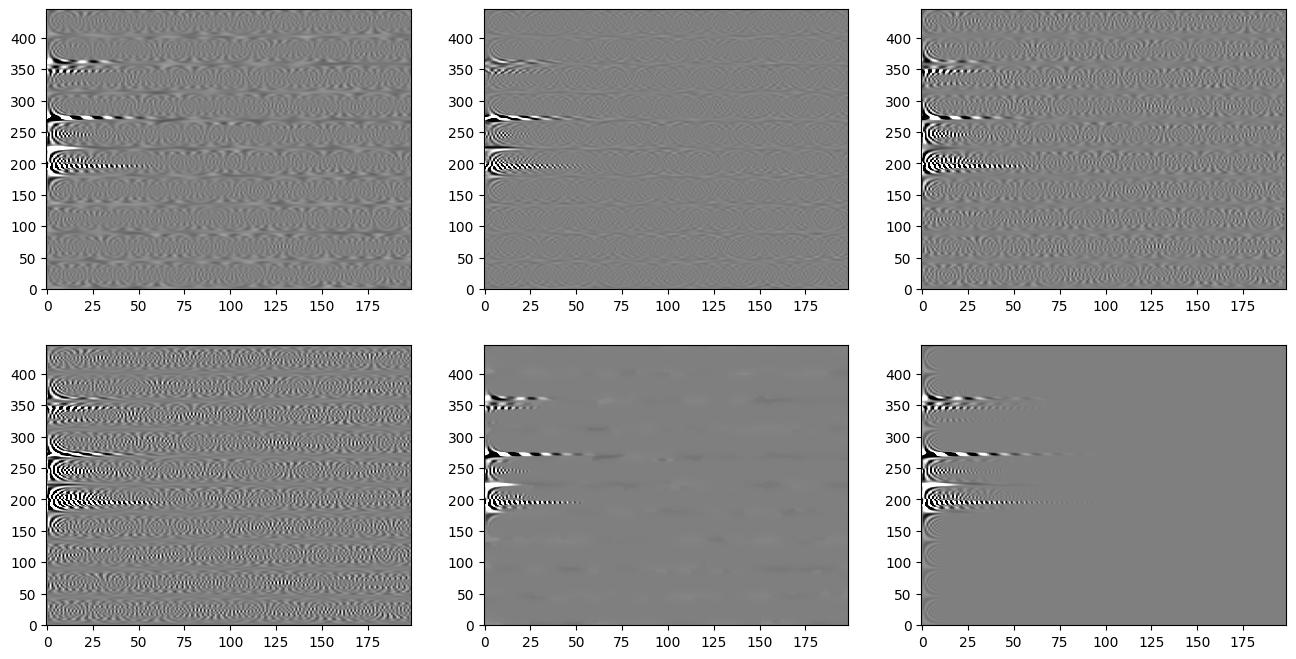

In [55]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(16,8))
vmin_ = np.mean(np.real(spgram_gt_normABS[0,:,:]))-2*np.std(np.real(spgram_gt_normABS[0,:,:]))
vmax_ = np.mean(np.real(spgram_gt_normABS[0,:,:]))+2*np.std(np.real(spgram_gt_normABS[0,:,:]))

ax[0,0].imshow(np.real(spgram_corrupted_avgs_normABS)[0,:,:], origin='lower', aspect='auto', cmap='gray',vmin=vmin_, vmax = vmax_)
ax[0,1].imshow(grad[0,0,:,:], origin='lower', aspect='auto', cmap='gray',vmin=vmin_, vmax = vmax_)
ax[0,2].imshow(grad[0,1,:,:], origin='lower', aspect='auto', cmap='gray',vmin=vmin_, vmax = vmax_)
ax[1,0].imshow(div[0,:,:], origin='lower', aspect='auto', cmap='gray',vmin=vmin_, vmax = vmax_)
ax[1,1].imshow(filtered_TV[0,:,:], origin='lower', aspect='auto', cmap='gray',vmin=vmin_, vmax = vmax_)
ax[1,2].imshow(np.real(spgram_gt_normABS)[0,:,:], origin='lower', aspect='auto', cmap='gray',vmin=vmin_, vmax = vmax_)

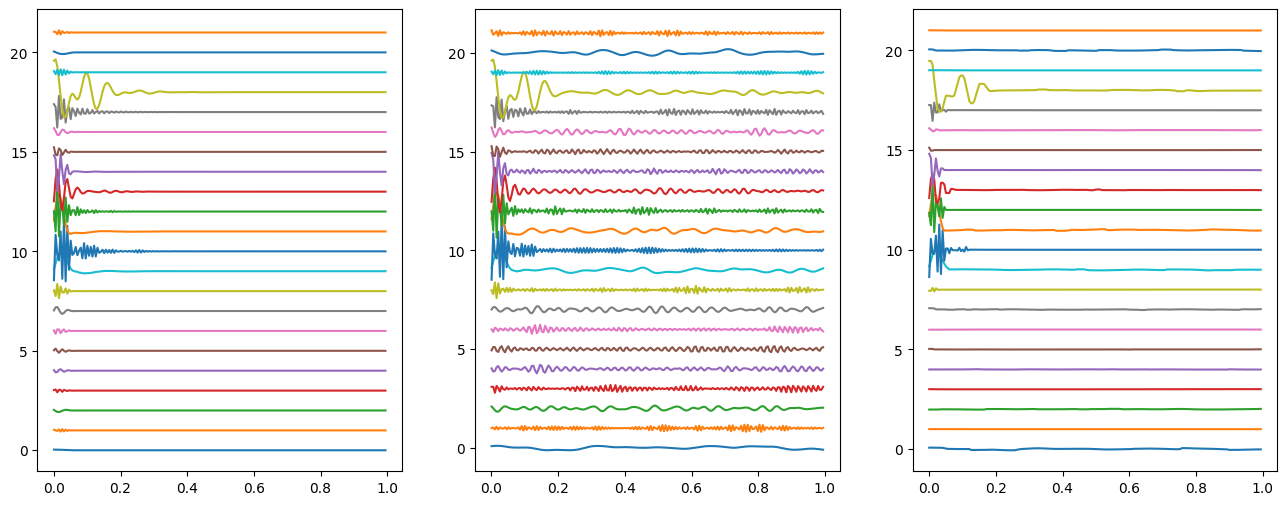

In [59]:
fig, ax = plt.subplots(1,3, figsize=(16,6))
offset = 1
for i in range(int(np.round(spgram_gt_normABS.shape[1]/20))):
    ax[0].plot(t_spect,np.real(spgram_gt_normABS[idx,i*20,:])*20+offset*i)
    ax[1].plot(t_spect,np.real(spgram_corrupted_avgs_normABS[idx,i*20,:])*20+offset*i)
    ax[2].plot(t_spect,np.real(filtered_TV[idx,i*20,:])*20+offset*i)